In [1]:
!pip install DeepMIMO==2

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install sionna

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!python --version

Python 3.11.9


In [4]:
!pip install numpy==2.0.2

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 89.8 MB/s eta 0:00:00:00:0100:01


In [5]:
###### Deep Learning Coordinated Beamforming with DeepMIMO #################
# Author: Umut Demirhan, Ahmed Alkhateeb
# Date: March 19, 2022
# Paper: A. Alkhateeb, S. Alex, P. Varkey, Y. Li, Q. Qu and D. Tujkovic,
# "Deep Learning Coordinated Beamforming for Highly-Mobile Millimeter Wave
# Systems," in IEEE Access, vol. 6, pp. 37328-37348, 2018.
###########################################################################

# import DeepMIMO
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
from scipy.io import loadmat, savemat
import glob
import re
import sionna.rt
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, \
                      PathSolver, RadioMapSolver, subcarrier_frequencies
plt.rcParams['figure.figsize'] = [12, 8] # Set default plot size




KeyboardInterrupt



In [ ]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):

    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate

    vecs = []
    for dim in range(3):
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)

    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))

    return F



In [ ]:
# !unzip meshes.zip

In [ ]:
# scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge shapes to speed-up computations
scene = load_scene("DeepMIMOScenario01Envtest2.xml", merge_shapes=True)
my_cam = Camera(position=[0, 0, 1000], look_at=[0,0,0])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[1300, 1000], num_samples=512);

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

tx_positions = [
    [30, -39, 30],
    [90, -39, 30],
    [30, 6,  30],
    [90, 6, 30]
]

# Create a receiver
rx = Receiver(name="rx",
              position=[50,-20,10],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

for i, pos in enumerate(tx_positions):
    tx = Transmitter(name=f"tx{i+1}", position=pos, display_radius=2)
    scene.add(tx)
    tx.look_at(rx)


#tx.look_at(rx)


In [ ]:
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

In [ ]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

Shape of a:  (1, 2, 4, 1, 1, 1)
Shape of tau:  (1, 2, 4, 1, 1)


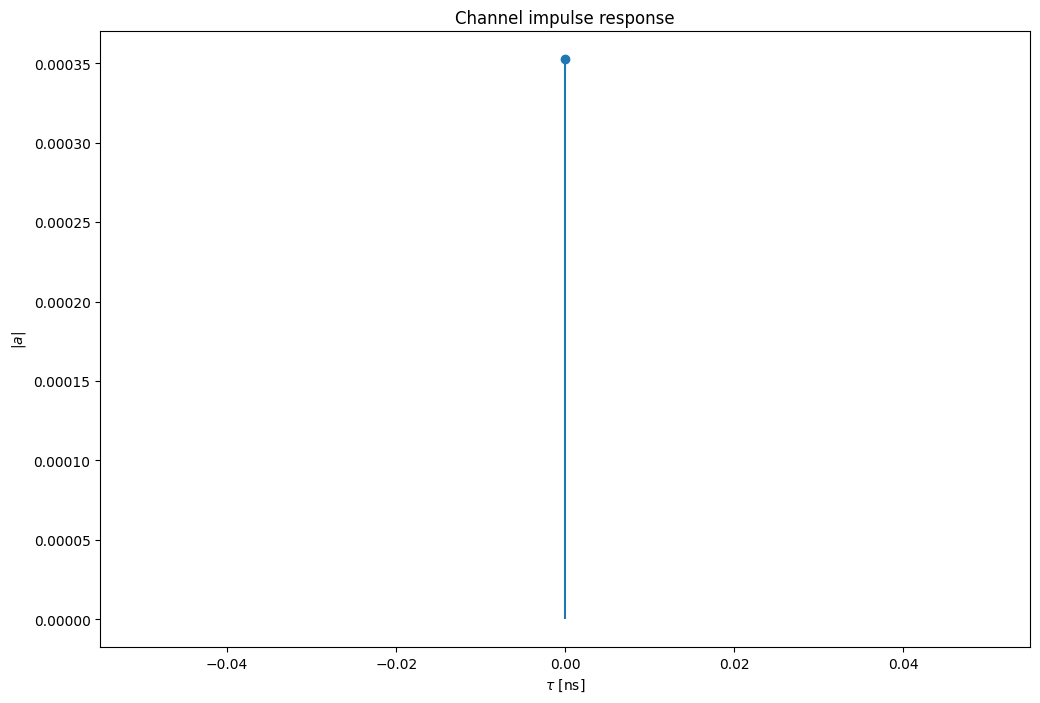

In [ ]:
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [ ]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

Shape of h_freq:  (1, 2, 4, 1, 1, 1024)


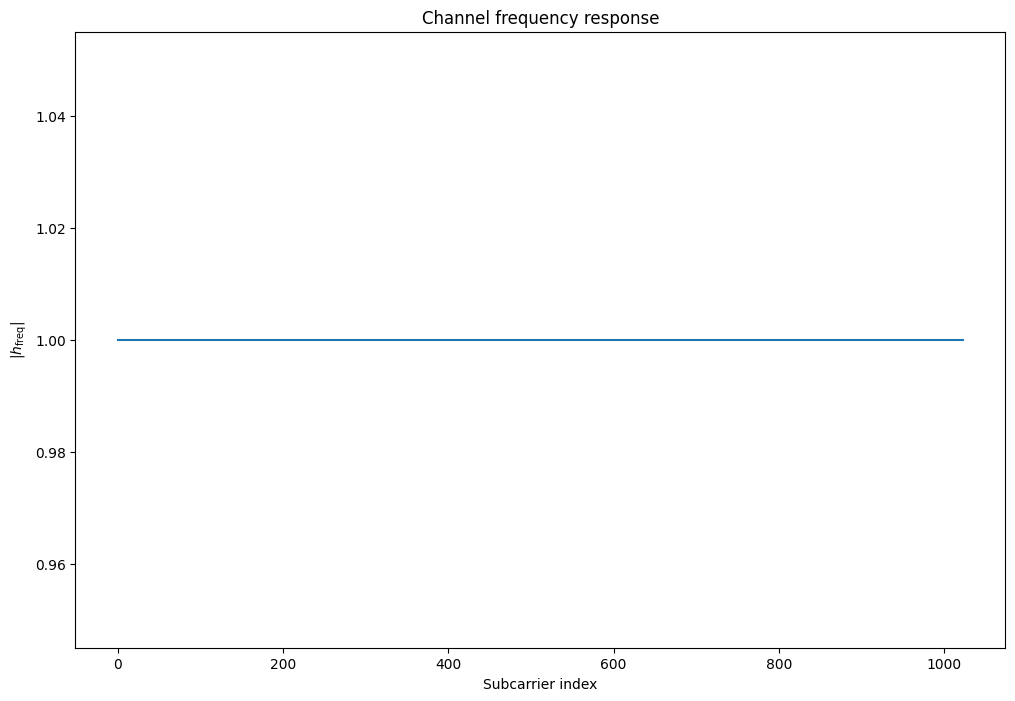

In [ ]:
num_subcarriers = 1024
subcarrier_spacing=30e3

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

Shape of taps:  (1, 2, 4, 1, 1, 107)


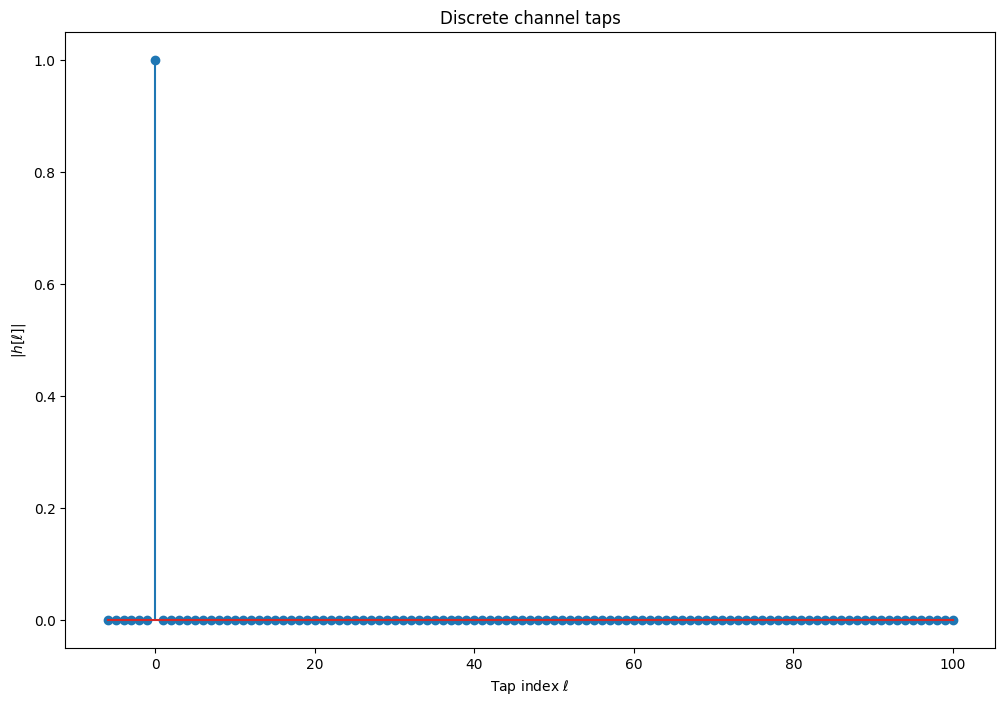

In [ ]:
taps = paths.taps(bandwidth=100e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=-6,        # Smallest time lag
                  l_max=100,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 101), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

In [ ]:
# scene.get("tx").velocity = [10, 0, 0]

# Recompute propagation paths
paths_mob = p_solver(scene=scene,
                     max_depth=5,
                     los=True,
                     specular_reflection=True,
                     diffuse_reflection=False,
                     refraction=True,
                     synthetic_array=True,
                     seed=41)

# Compute CIR with time-evolution
num_time_steps=100
sampling_frequency = 1e4
a_mob, _ = paths_mob.cir(sampling_frequency=sampling_frequency,
                         num_time_steps=num_time_steps,
                         out_type="numpy")

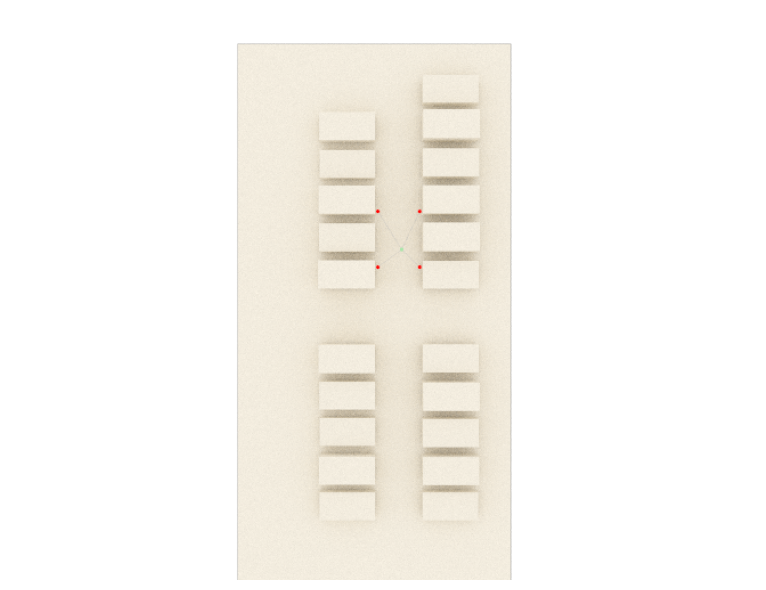

In [ ]:
scene.render(camera=my_cam, paths=paths_mob, clip_at=1000);

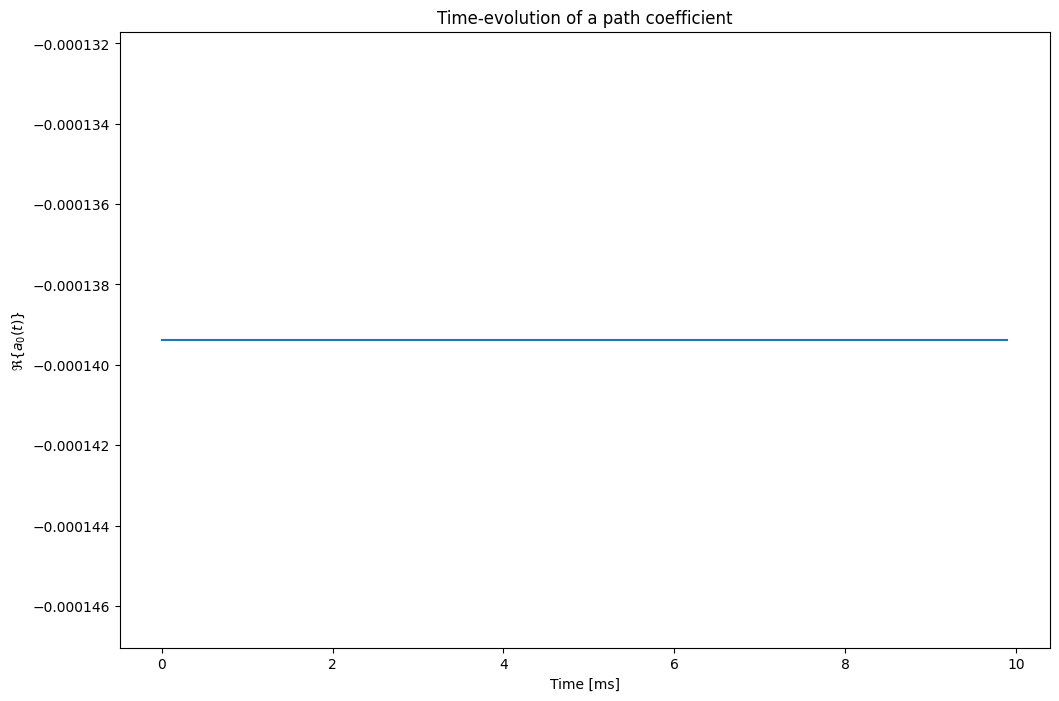

In [ ]:
# Inspect time-evolution of a single path coefficient
plt.figure()
plt.plot(np.arange(num_time_steps)/sampling_frequency*1000,
         a_mob[0,0,0,0,0].real);
plt.xlabel("Time [ms]");
plt.ylabel(r"$\Re\{a_0(t) \}$");
plt.title("Time-evolution of a path coefficient");

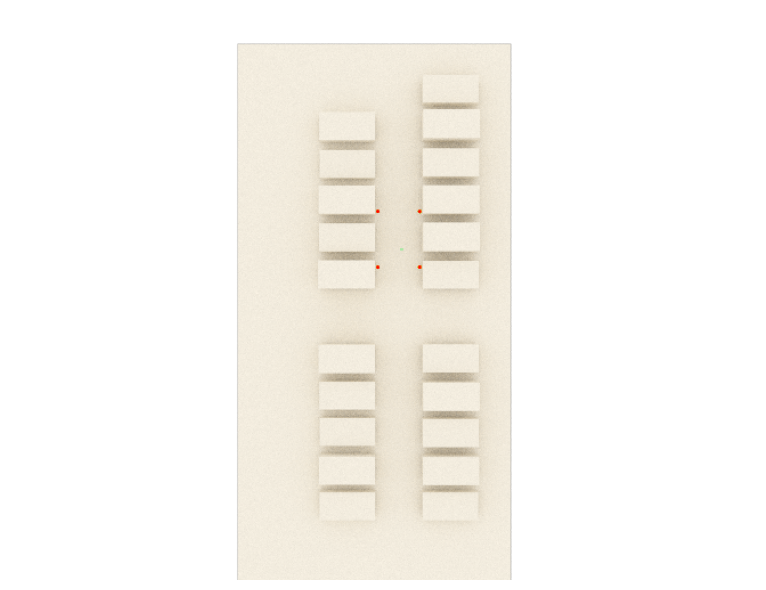

In [ ]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[1,1],
               samples_per_tx=10**6)

scene.render(camera=my_cam, radio_map=rm);

In [24]:
print("Interactions: \n", paths.interactions.numpy()[:,0,0,0,0,:])

print("Number of paths: ", paths.interactions.shape[-1])

NameError: name 'paths' is not defined

In [31]:
sionna_data = loadmat('DLCB_input_squeezed.mat')

In [32]:
print(sionna_data['DL_input'])

[[[        nan       +nanj         nan       +nanj
           nan       +nanj ...         nan       +nanj
           nan       +nanj         nan       +nanj]
  [-0.6808187 -0.7324522j  -0.6808187 -0.7324522j
   -0.6808187 -0.7324522j  ... -0.6808187 -0.7324522j
   -0.6808187 -0.7324522j  -0.6808187 -0.7324522j ]
  [-0.9868448 -0.16166787j -0.9868448 -0.16166787j
   -0.9868448 -0.16166787j ... -0.9868448 -0.16166787j
   -0.9868448 -0.16166787j -0.9868448 -0.16166787j]
  [-0.3138815 -0.9494626j  -0.3138815 -0.9494626j
   -0.3138815 -0.9494626j  ... -0.3138815 -0.9494626j
   -0.3138815 -0.9494626j  -0.3138815 -0.9494626j ]]

 [[ 0.49909136-0.8665497j   0.49909136-0.8665497j
    0.49909136-0.8665497j  ...  0.49909136-0.8665497j
    0.49909136-0.8665497j   0.49909136-0.8665497j ]
  [-0.69768894-0.71640056j -0.69768894-0.71640056j
   -0.69768894-0.71640056j ... -0.69768894-0.71640056j
   -0.69768894-0.71640056j -0.69768894-0.71640056j]
  [-0.9868019 -0.16193411j -0.9868019 -0.16193411j
   -0

In [33]:
print(sionna_data['DL_input'].shape)

(18100, 4, 64)


In [34]:
other_data = loadmat('DLCB_dataset/DLCB_input.mat')
print(other_data)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu May 29 05:51:26 2025', '__version__': '1.0', '__globals__': [], 'DL_input': array([[ 0.04763118+0.09675292j,  0.04763118+0.09675292j,
         0.04763118+0.09675292j, ...,  0.04763118+0.09675292j,
         0.04763118+0.09675292j,  0.04763118+0.09675292j],
       [-0.21100929-0.02244659j, -0.21100929-0.02244659j,
        -0.21100929-0.02244659j, ..., -0.21100929-0.02244659j,
        -0.21100929-0.02244659j, -0.21100929-0.02244659j],
       [ 0.44817152+0.0488978j ,  0.44817152+0.0488978j ,
         0.44817152+0.0488978j , ...,  0.44817152+0.0488978j ,
         0.44817152+0.0488978j ,  0.44817152+0.0488978j ],
       ...,
       [ 0.85171564-0.08483117j,  0.85171564-0.08483117j,
         0.85171564-0.08483117j, ...,  0.85171564-0.08483117j,
         0.85171564-0.08483117j,  0.85171564-0.08483117j],
       [-0.59979862-0.48934326j, -0.59979862-0.48934326j,
        -0.59979862-0.48934326j, ..., -0.59979862-0.48934326j,
 

In [35]:
DL_input = sionna_data['DL_input']
valid_ues_mask = ~np.isnan(DL_input).any(axis=(1, 2))

clean_DL_input = DL_input[valid_ues_mask, :, :]

print(f"Original shape: {DL_input.shape}")
print(f"Cleaned shape: {clean_DL_input.shape}")

sionna_data['DL_input'] = clean_DL_input

Original shape: (18100, 4, 64)
Cleaned shape: (18099, 4, 64)


In [14]:
import DeepMIMO
# # Load and print the default parameters
parameters = DeepMIMO.default_params()


# # Change parameters for the setup
# Scenario O1_60 extracted at the dataset_folder
parameters['scenario'] = 'O1_60'
parameters['dataset_folder'] = '' # Set DeepMIMO dataset folder that has O1_60

parameters['num_paths'] = 5

# User rows 1-100
parameters['user_row_first'] = 1000
parameters['user_row_last'] = 1100

# Activate only the first basestation
#parameters['active_BS'] = np.array([3, 4, 5, 6]) 

parameters['active_BS'] = np.array([3]) 


parameters['OFDM']['bandwidth'] = 0.5 # 50 MHz
parameters['OFDM']['subcarriers'] = 1024 # OFDM with 512 subcarriers
parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

parameters['enable_BS2BS'] = False

parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # Single antenna
parameters['bs_antenna']['shape'] = np.array([1, 32, 8]) # ULA of 32 elements
parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'
pprint(parameters)

{'OFDM': {'RX_filter': 0,
          'bandwidth': 0.5,
          'subcarriers': 1024,
          'subcarriers_limit': 64,
          'subcarriers_sampling': 1},
 'OFDM_channels': 1,
 'active_BS': array([3]),
 'bs_antenna': {'radiation_pattern': 'halfwave-dipole',
                'shape': array([ 1, 32,  8]),
                'spacing': 0.5},
 'dataset_folder': '',
 'dynamic_settings': {'first_scene': 1, 'last_scene': 1},
 'enable_BS2BS': False,
 'num_paths': 5,
 'row_subsampling': 1,
 'scenario': 'O1_60',
 'ue_antenna': {'radiation_pattern': 'halfwave-dipole',
                'shape': array([1, 1, 1]),
                'spacing': 0.5},
 'user_row_first': 1000,
 'user_row_last': 1100,
 'user_subsampling': 1}


In [36]:
#%% Parameters and Codebook
F = beamforming_codebook(ant_shape = parameters['bs_antenna'][0]['shape'], oversampling_rate = np.array([1, 2, 1]), kd = parameters['bs_antenna'][0]['spacing'])

num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_beams = F.shape[1]
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])



NF = 5             # Noise figure at the base station
Process_Gain = 10  # Channel estimation processing gain
BW = parameters['OFDM']['bandwidth'] * 1e9 # System bandwidth in Hz
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain; # Noise power in dB
noise_power = 10**(.1*(noise_power_dB)); # Noise power

#%% DL Input-Output
input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
max_rates = np.zeros((num_bs, num_ue, num_beams))


NameError: name 'parameters' is not defined

In [37]:
# Define antenna shape and spacing (BS-side)
ant_shape = [1, 1, 64]  # Based on DeepMIMO config
kd = 0.5  # Half-wavelength spacing

# Generate beamforming codebook
F = beamforming_codebook(ant_shape=ant_shape, oversampling_rate=np.array([1, 2, 1]), kd=kd)

# Extract info from Sionna data
DL_input = sionna_data['DL_input']  # shape: (18100, 4, 64)
num_ue = DL_input.shape[0]
num_rx_ant = DL_input.shape[1]
num_OFDM = DL_input.shape[2]
num_beams = F.shape[1]
num_bs = 4  # Single base station assumed

# System-level constants
NF = 5  # Noise figure (dB)
Process_Gain = 10  # Processing gain (dB)
BW = 0.5e9  # 500 MHz total bandwidth
subcarriers = 64

# Compute noise power
noise_power_dB = -204 + 10 * np.log10(BW / subcarriers) + NF - Process_Gain
noise_power = 10 ** (0.1 * noise_power_dB)

# Preallocate output arrays
input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
max_rates = np.zeros((num_bs, num_ue, num_beams))


In [38]:
#for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
from tqdm import tqdm

for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
    for bs_idx in range(num_bs):
        ch = sionna_data['DL_input'][ue_idx, bs_idx, :] 
        noise = np.sqrt(noise_power) * (np.random.randn(*ch.shape) + 1j * np.random.randn(*ch.shape))
        ch_noisy = ch + noise
        # ch_noisy = np.nan_to_num(ch_noisy)
        if ch_noisy is np.nan:
            print("Issue")
        input_norm[bs_idx, ue_idx, :] = ch_noisy
        snr = np.abs(ch_noisy)**2
        rate = np.sum(np.log2(1 + snr)) / num_OFDM
        if rate is np.nan:
            print("Issue")
        # rate = np.nan_to_num(rate)
        max_rates[bs_idx, ue_idx, :] = rate

Neural Network Input-Output Generation-BS: 100%|██████████| 18099/18099 [00:02<00:00, 6928.69it/s]


In [49]:
# Input reshape - normalize
input_norm = np.transpose(input_norm, axes=[1, 0, 2])
input_norm = input_norm.reshape((num_ue, -1))
input_norm /=  np.amax(np.abs(input_norm))

# Output reshape - normalize
max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
max_rates_norm_factor[max_rates_norm_factor== 0] = 1 # Do not normalize if all zeros
max_rates /= max_rates_norm_factor
max_rates = np.transpose(max_rates, axes=[1, 0, 2])
max_rates = max_rates.reshape((num_ue, -1))

if not os.path.exists('./Test_dataset'):
                      os.makedirs('Test_dataset')
savemat('./Test_dataset/DLCB_input.mat', {'DL_input': input_norm})
savemat('./Test_dataset/DLCB_output.mat', {'DL_output': max_rates})



In [7]:
other_data = sionna_data = loadmat('./Test_dataset/DLCB_output.mat')
print(other_data)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Jun  1 18:59:42 2025', '__version__': '1.0', '__globals__': [], 'DL_output': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])}


In [14]:
!pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable


In [16]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable


In [50]:
# %% Machine Learning
import os
import keras
import keras.models as models
from keras.layers import Dense,Dropout
import numpy as np

# Model training function
def train(In_train, Out_train, In_test, Out_test,
          epochs, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):

    in_shp = list(In_train.shape[1:])

    AP_models = []
    for bs_idx in range(n_BS):
        idx_str = 'BS%i' % bs_idx
        idx = bs_idx*n_beams

        model = models.Sequential()
        model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=in_shp))
        model.add(Dropout(dr))
        for h in range(num_hidden_layers):
            model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
            model.add(Dropout(dr))

        model.add(Dense(n_beams, activation='relu', kernel_initializer='he_normal',
                  name="dense" + idx_str + "o"))
        model.compile(loss=loss_fn, optimizer='adam')
        model.summary()

        print(Out_train[:, idx:idx + n_beams].shape)
        model.fit(In_train,
                    Out_train[:, idx:idx + n_beams],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
                    callbacks = [
                        #keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])

        AP_models.append(model)


    return AP_models


In [4]:
from scipy.io import loadmat, savemat

In [52]:
idk=loadmat('DLCB_dataset/DLCB_input.mat')
idk = idk['DL_input']
idk2=loadmat('DLCB_dataset/DLCB_output.mat')
idk2 = idk2['DL_output']

In [53]:
print(idk.shape)
print(idk2.shape)

(100, 64)
(100, 64)


In [54]:
print(In_set.shape)
print(Out_set.shape)

(18100, 256)
(18100, 512)


In [55]:
print(Out_set_file)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Jun  1 18:24:27 2025', '__version__': '1.0', '__globals__': [], 'DL_output': array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])}


In [56]:
# Reading input and output sets generated from MATLAB
In_set_file=loadmat('Test_dataset/DLCB_input.mat')
Out_set_file=loadmat('Test_dataset/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]
n_DL_size=[0.001, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7]
count=0
num_tot_TX=4
num_beams=2

for DL_size_ratio in n_DL_size:

    print (DL_size_ratio)
    count=count+1
    DL_size=int(num_user_tot*DL_size_ratio)

    np.random.seed(2016)
    n_examples = DL_size
    num_train  = int(DL_size * 0.8)
    num_test   = int(num_user_tot*.2)

    train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
    rem_index = set(range(0,num_user_tot))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))

    In_train = In_set[train_index]
    In_test =  In_set[test_index]

    Out_train = Out_set[train_index]
    Out_test = Out_set[test_index]


    # Learning model parameters
    epochs = 10
    batch_size = 100
    dr = 0.05                  # dropout rate
    num_hidden_layers=4
    nodes_per_layer=In_train.shape[1]
    loss_fn='mean_squared_error'

    # Model training
    AP_models = train(In_train, Out_train, In_test, Out_test,
                                          epochs, batch_size,dr,
                                          num_hidden_layers, nodes_per_layer,
                                          loss_fn,num_tot_TX,num_beams)


    # Model running/testing
    DL_Result={}
    for idx in range(0,num_tot_TX,1):
        beams_predicted=AP_models[idx].predict( In_test, batch_size=10, verbose=0)

        DL_Result['TX'+str(idx+1)+'Pred_Beams']=beams_predicted
        DL_Result['TX'+str(idx+1)+'Opt_Beams']=Out_test[:,idx*num_beams:(idx+1)*num_beams]

    DL_Result['user_index']=test_index


    if not os.path.exists('./Test_code_output'):
                          os.makedirs('Test_code_output')
    savemat('Test_code_output/DL_Result'+str(count)+'.mat',DL_Result)


0.001


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_300 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_301 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_302 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_304 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10
1/1 - 4s - 4s/step - loss: 0.7562 - val_loss: 1.0000
Epoch 2/10
1/1 - 0s - 322ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/10
1/1 - 0s - 283ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/10
1/1 - 0s - 328ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/10
1/1 - 0s - 289ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/10
1/1 - 0s - 289ms/step - loss: 0.9886 - val_loss: 0.9991
Epoch 7/10
1/1 - 0s - 294ms/step - loss: 1.0000 - val_loss: 0.9655
Epoch 8/10
1/1 - 0s - 264ms/step - loss: 0.9031 - val_loss: 0.9302
Epoch 9/10
1/1 - 0s - 309ms/step - loss: 0.8897 - val_loss: 1.0060
Epoch 10/10
1/1 - 0s - 379ms/step - loss: 0.8945 - val_loss: 0.8171


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_305 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_305 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_306 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_307 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_308 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_308 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_309 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10
1/1 - 4s - 4s/step - loss: 0.7911 - val_loss: 1.0000
Epoch 2/10
1/1 - 0s - 304ms/step - loss: 0.9898 - val_loss: 1.0000
Epoch 3/10
1/1 - 0s - 287ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/10
1/1 - 0s - 386ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/10
1/1 - 0s - 263ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/10
1/1 - 0s - 298ms/step - loss: 1.0000 - val_loss: 1.0000


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_310 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_310 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_311 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_312 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_313 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_314 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10
1/1 - 4s - 4s/step - loss: 0.8913 - val_loss: 1.6532
Epoch 2/10
1/1 - 0s - 364ms/step - loss: 1.7633 - val_loss: 0.8246
Epoch 3/10
1/1 - 0s - 296ms/step - loss: 0.7920 - val_loss: 0.9936
Epoch 4/10
1/1 - 0s - 288ms/step - loss: 0.9319 - val_loss: 0.9814
Epoch 5/10
1/1 - 0s - 262ms/step - loss: 0.9716 - val_loss: 0.9541
Epoch 6/10
1/1 - 0s - 269ms/step - loss: 0.9601 - val_loss: 0.9452
Epoch 7/10
1/1 - 0s - 264ms/step - loss: 0.9649 - val_loss: 0.9426


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_315 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_316 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_317 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_318 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_319 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10
1/1 - 4s - 4s/step - loss: 0.9363 - val_loss: 1.4604
Epoch 2/10
1/1 - 0s - 314ms/step - loss: 1.6670 - val_loss: 0.9389
Epoch 3/10
1/1 - 0s - 311ms/step - loss: 0.9006 - val_loss: 0.9960
Epoch 4/10
1/1 - 0s - 294ms/step - loss: 0.9861 - val_loss: 0.8569
Epoch 5/10
1/1 - 0s - 316ms/step - loss: 0.8750 - val_loss: 0.6117
Epoch 6/10
1/1 - 0s - 320ms/step - loss: 0.6981 - val_loss: 0.6529
Epoch 7/10
1/1 - 0s - 266ms/step - loss: 0.7822 - val_loss: 0.6262
Epoch 8/10
1/1 - 0s - 307ms/step - loss: 0.6762 - val_loss: 0.7265
Epoch 9/10
1/1 - 0s - 297ms/step - loss: 0.7350 - val_loss: 0.7142
Epoch 10/10
1/1 - 0s - 316ms/step - loss: 0.7471 - val_loss: 0.6615
0.05


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_320 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_320 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_321 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_322 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_322 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_323 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_324 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(723, 2)
Epoch 1/10
8/8 - 7s - 850ms/step - loss: 0.9865 - val_loss: 0.5826
Epoch 2/10
8/8 - 0s - 44ms/step - loss: 0.5748 - val_loss: 0.5261
Epoch 3/10
8/8 - 0s - 41ms/step - loss: 0.5408 - val_loss: 0.5165
Epoch 4/10
8/8 - 0s - 42ms/step - loss: 0.5236 - val_loss: 0.5136
Epoch 5/10
8/8 - 0s - 39ms/step - loss: 0.5213 - val_loss: 0.5156
Epoch 6/10
8/8 - 0s - 42ms/step - loss: 0.5177 - val_loss: 0.5169
Epoch 7/10
8/8 - 0s - 40ms/step - loss: 0.5146 - val_loss: 0.5073
Epoch 8/10
8/8 - 0s - 40ms/step - loss: 0.5149 - val_loss: 0.5097
Epoch 9/10
8/8 - 0s - 44ms/step - loss: 0.5131 - val_loss: 0.5155
Epoch 10/10
8/8 - 0s - 39ms/step - loss: 0.5130 - val_loss: 0.5143


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_325 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_325 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_326 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_327 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_328 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_329 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(723, 2)
Epoch 1/10
8/8 - 6s - 796ms/step - loss: 0.7135 - val_loss: 0.5818
Epoch 2/10
8/8 - 0s - 42ms/step - loss: 0.5789 - val_loss: 0.5320
Epoch 3/10
8/8 - 0s - 40ms/step - loss: 0.5424 - val_loss: 0.5245
Epoch 4/10
8/8 - 0s - 41ms/step - loss: 0.5287 - val_loss: 0.5180
Epoch 5/10
8/8 - 0s - 41ms/step - loss: 0.5223 - val_loss: 0.5102
Epoch 6/10
8/8 - 0s - 41ms/step - loss: 0.5165 - val_loss: 0.5119
Epoch 7/10
8/8 - 0s - 36ms/step - loss: 0.5137 - val_loss: 0.5078
Epoch 8/10
8/8 - 0s - 41ms/step - loss: 0.5126 - val_loss: 0.5119
Epoch 9/10
8/8 - 0s - 38ms/step - loss: 0.5110 - val_loss: 0.5084
Epoch 10/10
8/8 - 0s - 41ms/step - loss: 0.5100 - val_loss: 0.5111


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_330 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_330 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_331 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_332 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_333 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_334 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(723, 2)
Epoch 1/10
8/8 - 6s - 780ms/step - loss: 1.0294 - val_loss: 0.5882
Epoch 2/10
8/8 - 0s - 45ms/step - loss: 0.5949 - val_loss: 0.5437
Epoch 3/10
8/8 - 0s - 55ms/step - loss: 0.5438 - val_loss: 0.5182
Epoch 4/10
8/8 - 0s - 37ms/step - loss: 0.5246 - val_loss: 0.5121
Epoch 5/10
8/8 - 0s - 41ms/step - loss: 0.5202 - val_loss: 0.5191
Epoch 6/10
8/8 - 0s - 40ms/step - loss: 0.5181 - val_loss: 0.5101
Epoch 7/10
8/8 - 0s - 41ms/step - loss: 0.5152 - val_loss: 0.5161
Epoch 8/10
8/8 - 0s - 42ms/step - loss: 0.5142 - val_loss: 0.5136
Epoch 9/10
8/8 - 0s - 42ms/step - loss: 0.5127 - val_loss: 0.5114
Epoch 10/10
8/8 - 0s - 42ms/step - loss: 0.5119 - val_loss: 0.5167


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_335 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_335 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_336 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_337 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_338 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_339 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(723, 2)
Epoch 1/10
8/8 - 6s - 794ms/step - loss: 0.6939 - val_loss: 0.2195
Epoch 2/10
8/8 - 0s - 40ms/step - loss: 0.1752 - val_loss: 0.0610
Epoch 3/10
8/8 - 0s - 37ms/step - loss: 0.0665 - val_loss: 0.0305
Epoch 4/10
8/8 - 0s - 40ms/step - loss: 0.0392 - val_loss: 0.0189
Epoch 5/10
8/8 - 0s - 48ms/step - loss: 0.0300 - val_loss: 0.0170
Epoch 6/10
8/8 - 0s - 44ms/step - loss: 0.0250 - val_loss: 0.0240
Epoch 7/10
8/8 - 0s - 39ms/step - loss: 0.0240 - val_loss: 0.0156
Epoch 8/10
8/8 - 0s - 40ms/step - loss: 0.0218 - val_loss: 0.0202
Epoch 9/10
8/8 - 0s - 43ms/step - loss: 0.0206 - val_loss: 0.0228
Epoch 10/10
8/8 - 0s - 41ms/step - loss: 0.0189 - val_loss: 0.0189
0.1


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_340 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_340 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_341 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_342 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_343 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_344 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1447, 2)
Epoch 1/10
15/15 - 7s - 446ms/step - loss: 0.7590 - val_loss: 0.5208
Epoch 2/10
15/15 - 0s - 26ms/step - loss: 0.5357 - val_loss: 0.5145
Epoch 3/10
15/15 - 0s - 24ms/step - loss: 0.5184 - val_loss: 0.5100
Epoch 4/10
15/15 - 0s - 26ms/step - loss: 0.5139 - val_loss: 0.5167
Epoch 5/10
15/15 - 0s - 30ms/step - loss: 0.5118 - val_loss: 0.5093
Epoch 6/10
15/15 - 0s - 24ms/step - loss: 0.5104 - val_loss: 0.5149
Epoch 7/10
15/15 - 0s - 24ms/step - loss: 0.5094 - val_loss: 0.5088
Epoch 8/10
15/15 - 0s - 23ms/step - loss: 0.5081 - val_loss: 0.5137
Epoch 9/10
15/15 - 0s - 25ms/step - loss: 0.5076 - val_loss: 0.5080
Epoch 10/10
15/15 - 0s - 24ms/step - loss: 0.5071 - val_loss: 0.5120


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_345 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_345 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_346 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_347 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_348 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_349 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1447, 2)
Epoch 1/10
15/15 - 6s - 429ms/step - loss: 0.4128 - val_loss: 0.0576
Epoch 2/10
15/15 - 0s - 23ms/step - loss: 0.0567 - val_loss: 0.0378
Epoch 3/10
15/15 - 0s - 23ms/step - loss: 0.0317 - val_loss: 0.0285
Epoch 4/10
15/15 - 0s - 23ms/step - loss: 0.0229 - val_loss: 0.0224
Epoch 5/10
15/15 - 0s - 28ms/step - loss: 0.0201 - val_loss: 0.0208
Epoch 6/10
15/15 - 0s - 28ms/step - loss: 0.0170 - val_loss: 0.0231
Epoch 7/10
15/15 - 0s - 25ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 8/10
15/15 - 0s - 25ms/step - loss: 0.0134 - val_loss: 0.0113
Epoch 9/10
15/15 - 0s - 23ms/step - loss: 0.0121 - val_loss: 0.0219
Epoch 10/10
15/15 - 0s - 23ms/step - loss: 0.0112 - val_loss: 0.0223


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_350 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_351 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_352 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_353 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_354 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1447, 2)
Epoch 1/10
15/15 - 7s - 435ms/step - loss: 0.5607 - val_loss: 0.1543
Epoch 2/10
15/15 - 0s - 24ms/step - loss: 0.0853 - val_loss: 0.0354
Epoch 3/10
15/15 - 0s - 25ms/step - loss: 0.0351 - val_loss: 0.0211
Epoch 4/10
15/15 - 0s - 24ms/step - loss: 0.0235 - val_loss: 0.0139
Epoch 5/10
15/15 - 0s - 25ms/step - loss: 0.0198 - val_loss: 0.0215
Epoch 6/10
15/15 - 0s - 32ms/step - loss: 0.0170 - val_loss: 0.0194
Epoch 7/10
15/15 - 0s - 25ms/step - loss: 0.0149 - val_loss: 0.0202
Epoch 8/10
15/15 - 0s - 24ms/step - loss: 0.0137 - val_loss: 0.0101
Epoch 9/10
15/15 - 0s - 25ms/step - loss: 0.0130 - val_loss: 0.0225
Epoch 10/10
15/15 - 0s - 27ms/step - loss: 0.0116 - val_loss: 0.0192


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_355 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_355 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_356 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_357 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_358 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_359 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1447, 2)
Epoch 1/10
15/15 - 8s - 540ms/step - loss: 0.7341 - val_loss: 0.3411
Epoch 2/10
15/15 - 0s - 30ms/step - loss: 0.2242 - val_loss: 0.0792
Epoch 3/10
15/15 - 0s - 25ms/step - loss: 0.0598 - val_loss: 0.0393
Epoch 4/10
15/15 - 0s - 25ms/step - loss: 0.0306 - val_loss: 0.0129
Epoch 5/10
15/15 - 0s - 26ms/step - loss: 0.0230 - val_loss: 0.0303
Epoch 6/10
15/15 - 0s - 27ms/step - loss: 0.0201 - val_loss: 0.0193
Epoch 7/10
15/15 - 0s - 26ms/step - loss: 0.0161 - val_loss: 0.0175
Epoch 8/10
15/15 - 0s - 26ms/step - loss: 0.0145 - val_loss: 0.0162
Epoch 9/10
15/15 - 0s - 29ms/step - loss: 0.0135 - val_loss: 0.0168
0.15


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_360 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_360 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_361 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_362 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_363 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_364 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_364 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2171, 2)
Epoch 1/10
22/22 - 7s - 319ms/step - loss: 0.8895 - val_loss: 0.5209
Epoch 2/10
22/22 - 0s - 19ms/step - loss: 0.5251 - val_loss: 0.5099
Epoch 3/10
22/22 - 0s - 17ms/step - loss: 0.5144 - val_loss: 0.5102
Epoch 4/10
22/22 - 0s - 19ms/step - loss: 0.5107 - val_loss: 0.5102
Epoch 5/10
22/22 - 0s - 17ms/step - loss: 0.5094 - val_loss: 0.5071
Epoch 6/10
22/22 - 0s - 19ms/step - loss: 0.5082 - val_loss: 0.5083
Epoch 7/10
22/22 - 0s - 17ms/step - loss: 0.5070 - val_loss: 0.5074
Epoch 8/10
22/22 - 0s - 19ms/step - loss: 0.5063 - val_loss: 0.5093
Epoch 9/10
22/22 - 0s - 20ms/step - loss: 0.5055 - val_loss: 0.5099
Epoch 10/10
22/22 - 0s - 19ms/step - loss: 0.5052 - val_loss: 0.5065


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_365 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_365 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_366 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_367 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_368 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_369 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2171, 2)
Epoch 1/10
22/22 - 7s - 314ms/step - loss: 0.2667 - val_loss: 0.0368
Epoch 2/10
22/22 - 0s - 19ms/step - loss: 0.0411 - val_loss: 0.0234
Epoch 3/10
22/22 - 0s - 17ms/step - loss: 0.0244 - val_loss: 0.0217
Epoch 4/10
22/22 - 0s - 19ms/step - loss: 0.0202 - val_loss: 0.0255
Epoch 5/10
22/22 - 0s - 19ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 6/10
22/22 - 0s - 18ms/step - loss: 0.0136 - val_loss: 0.0188
Epoch 7/10
22/22 - 0s - 19ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 8/10
22/22 - 0s - 18ms/step - loss: 0.0098 - val_loss: 0.0130
Epoch 9/10
22/22 - 0s - 20ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 10/10
22/22 - 1s - 23ms/step - loss: 0.0074 - val_loss: 0.0090


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_370 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_371 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_372 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_373 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_374 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2171, 2)
Epoch 1/10
22/22 - 7s - 298ms/step - loss: 0.6186 - val_loss: 0.5158
Epoch 2/10
22/22 - 0s - 20ms/step - loss: 0.5231 - val_loss: 0.5191
Epoch 3/10
22/22 - 0s - 19ms/step - loss: 0.5149 - val_loss: 0.5125
Epoch 4/10
22/22 - 0s - 19ms/step - loss: 0.5116 - val_loss: 0.5119
Epoch 5/10
22/22 - 0s - 19ms/step - loss: 0.5096 - val_loss: 0.5122
Epoch 6/10
22/22 - 0s - 18ms/step - loss: 0.5082 - val_loss: 0.5116
Epoch 7/10
22/22 - 0s - 17ms/step - loss: 0.5070 - val_loss: 0.5068
Epoch 8/10
22/22 - 0s - 18ms/step - loss: 0.5061 - val_loss: 0.5082
Epoch 9/10
22/22 - 0s - 18ms/step - loss: 0.5054 - val_loss: 0.5069
Epoch 10/10
22/22 - 0s - 20ms/step - loss: 0.5050 - val_loss: 0.5085


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_375 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_375 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_376 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_377 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_378 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_379 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2171, 2)
Epoch 1/10
22/22 - 7s - 297ms/step - loss: 0.4157 - val_loss: 0.0610
Epoch 2/10
22/22 - 0s - 20ms/step - loss: 0.0498 - val_loss: 0.0201
Epoch 3/10
22/22 - 0s - 19ms/step - loss: 0.0241 - val_loss: 0.0163
Epoch 4/10
22/22 - 0s - 19ms/step - loss: 0.0183 - val_loss: 0.0224
Epoch 5/10
22/22 - 0s - 18ms/step - loss: 0.0159 - val_loss: 0.0144
Epoch 6/10
22/22 - 0s - 18ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 7/10
22/22 - 0s - 19ms/step - loss: 0.0114 - val_loss: 0.0183
Epoch 8/10
22/22 - 0s - 18ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/10
22/22 - 1s - 23ms/step - loss: 0.0080 - val_loss: 0.0096
Epoch 10/10
22/22 - 0s - 19ms/step - loss: 0.0071 - val_loss: 0.0084
0.2


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_380 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_380 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_381 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_382 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_383 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_384 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2895, 2)
Epoch 1/10
29/29 - 7s - 245ms/step - loss: 0.3121 - val_loss: 0.0351
Epoch 2/10
29/29 - 0s - 17ms/step - loss: 0.0345 - val_loss: 0.0184
Epoch 3/10
29/29 - 0s - 16ms/step - loss: 0.0233 - val_loss: 0.0301
Epoch 4/10
29/29 - 1s - 18ms/step - loss: 0.0198 - val_loss: 0.0178
Epoch 5/10
29/29 - 0s - 17ms/step - loss: 0.0166 - val_loss: 0.0228
Epoch 6/10
29/29 - 0s - 15ms/step - loss: 0.0147 - val_loss: 0.0188
Epoch 7/10
29/29 - 0s - 17ms/step - loss: 0.0121 - val_loss: 0.0161
Epoch 8/10
29/29 - 0s - 16ms/step - loss: 0.0104 - val_loss: 0.0175
Epoch 9/10
29/29 - 0s - 15ms/step - loss: 0.0095 - val_loss: 0.0196
Epoch 10/10
29/29 - 0s - 15ms/step - loss: 0.0081 - val_loss: 0.0123


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_385 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_385 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_386 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_387 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_388 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_389 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2895, 2)
Epoch 1/10
29/29 - 7s - 229ms/step - loss: 0.7113 - val_loss: 0.5221
Epoch 2/10
29/29 - 0s - 15ms/step - loss: 0.5237 - val_loss: 0.5084
Epoch 3/10
29/29 - 1s - 18ms/step - loss: 0.5132 - val_loss: 0.5114
Epoch 4/10
29/29 - 0s - 14ms/step - loss: 0.5103 - val_loss: 0.5156
Epoch 5/10
29/29 - 0s - 14ms/step - loss: 0.5090 - val_loss: 0.5117
Epoch 6/10
29/29 - 0s - 14ms/step - loss: 0.5076 - val_loss: 0.5084
Epoch 7/10
29/29 - 0s - 14ms/step - loss: 0.5063 - val_loss: 0.5115


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_390 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_390 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_391 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_392 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_392 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_393 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_394 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2895, 2)
Epoch 1/10
29/29 - 7s - 234ms/step - loss: 0.5778 - val_loss: 0.3333
Epoch 2/10
29/29 - 0s - 15ms/step - loss: 0.1043 - val_loss: 0.0236
Epoch 3/10
29/29 - 0s - 15ms/step - loss: 0.0264 - val_loss: 0.0180
Epoch 4/10
29/29 - 0s - 17ms/step - loss: 0.0194 - val_loss: 0.0130
Epoch 5/10
29/29 - 1s - 17ms/step - loss: 0.0158 - val_loss: 0.0213
Epoch 6/10
29/29 - 0s - 17ms/step - loss: 0.0128 - val_loss: 0.0174
Epoch 7/10
29/29 - 0s - 15ms/step - loss: 0.0110 - val_loss: 0.0164
Epoch 8/10
29/29 - 0s - 15ms/step - loss: 0.0096 - val_loss: 0.0115
Epoch 9/10
29/29 - 0s - 15ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 10/10
29/29 - 0s - 15ms/step - loss: 0.0064 - val_loss: 0.0076


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_395 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_395 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_396 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_397 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_398 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_399 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2895, 2)
Epoch 1/10
29/29 - 7s - 226ms/step - loss: 0.6745 - val_loss: 0.5166
Epoch 2/10
29/29 - 0s - 15ms/step - loss: 0.5170 - val_loss: 0.5157
Epoch 3/10
29/29 - 1s - 19ms/step - loss: 0.5111 - val_loss: 0.5125
Epoch 4/10
29/29 - 0s - 14ms/step - loss: 0.5091 - val_loss: 0.5138
Epoch 5/10
29/29 - 0s - 14ms/step - loss: 0.5077 - val_loss: 0.5151
Epoch 6/10
29/29 - 0s - 15ms/step - loss: 0.5067 - val_loss: 0.5095
Epoch 7/10
29/29 - 0s - 15ms/step - loss: 0.5055 - val_loss: 0.5073
Epoch 8/10
29/29 - 0s - 15ms/step - loss: 0.5047 - val_loss: 0.5056
Epoch 9/10
29/29 - 0s - 16ms/step - loss: 0.5038 - val_loss: 0.5054
Epoch 10/10
29/29 - 0s - 15ms/step - loss: 0.5032 - val_loss: 0.5046
0.25


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_400 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_400 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_401 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_402 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_403 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_404 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3619, 2)
Epoch 1/10
37/37 - 7s - 187ms/step - loss: 0.2744 - val_loss: 0.0256
Epoch 2/10
37/37 - 0s - 13ms/step - loss: 0.0305 - val_loss: 0.0222
Epoch 3/10
37/37 - 0s - 12ms/step - loss: 0.0211 - val_loss: 0.0154
Epoch 4/10
37/37 - 0s - 12ms/step - loss: 0.0166 - val_loss: 0.0191
Epoch 5/10
37/37 - 0s - 12ms/step - loss: 0.0130 - val_loss: 0.0232
Epoch 6/10
37/37 - 0s - 13ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 7/10
37/37 - 0s - 13ms/step - loss: 0.0084 - val_loss: 0.0108
Epoch 8/10
37/37 - 0s - 13ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/10
37/37 - 1s - 14ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 10/10
37/37 - 0s - 13ms/step - loss: 0.0043 - val_loss: 0.0043


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_405 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_405 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_406 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_407 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_408 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_409 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3619, 2)
Epoch 1/10
37/37 - 7s - 180ms/step - loss: 0.2837 - val_loss: 0.0365
Epoch 2/10
37/37 - 0s - 13ms/step - loss: 0.0281 - val_loss: 0.0168
Epoch 3/10
37/37 - 0s - 12ms/step - loss: 0.0177 - val_loss: 0.0146
Epoch 4/10
37/37 - 0s - 11ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 5/10
37/37 - 0s - 12ms/step - loss: 0.0107 - val_loss: 0.0157
Epoch 6/10
37/37 - 0s - 12ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 7/10
37/37 - 0s - 12ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 8/10
37/37 - 0s - 13ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 9/10
37/37 - 1s - 15ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 10/10
37/37 - 0s - 12ms/step - loss: 0.0037 - val_loss: 0.0032


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_410 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_410 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_411 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_412 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_413 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_414 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3619, 2)
Epoch 1/10
37/37 - 6s - 171ms/step - loss: 0.7037 - val_loss: 0.5112
Epoch 2/10
37/37 - 1s - 14ms/step - loss: 0.5150 - val_loss: 0.5150
Epoch 3/10
37/37 - 0s - 12ms/step - loss: 0.5107 - val_loss: 0.5086
Epoch 4/10
37/37 - 0s - 13ms/step - loss: 0.5076 - val_loss: 0.5078
Epoch 5/10
37/37 - 0s - 13ms/step - loss: 0.5065 - val_loss: 0.5072
Epoch 6/10
37/37 - 0s - 13ms/step - loss: 0.5051 - val_loss: 0.5067
Epoch 7/10
37/37 - 0s - 13ms/step - loss: 0.5041 - val_loss: 0.5048
Epoch 8/10
37/37 - 1s - 16ms/step - loss: 0.5035 - val_loss: 0.5028
Epoch 9/10
37/37 - 0s - 13ms/step - loss: 0.5029 - val_loss: 0.5028
Epoch 10/10
37/37 - 0s - 13ms/step - loss: 0.5023 - val_loss: 0.5024


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_415 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_415 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_416 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_417 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_418 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_419 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3619, 2)
Epoch 1/10
37/37 - 7s - 177ms/step - loss: 0.6469 - val_loss: 0.5135
Epoch 2/10
37/37 - 0s - 13ms/step - loss: 0.5140 - val_loss: 0.5116
Epoch 3/10
37/37 - 0s - 13ms/step - loss: 0.5107 - val_loss: 0.5131
Epoch 4/10
37/37 - 0s - 12ms/step - loss: 0.5088 - val_loss: 0.5168
Epoch 5/10
37/37 - 0s - 13ms/step - loss: 0.5072 - val_loss: 0.5096
Epoch 6/10
37/37 - 1s - 16ms/step - loss: 0.5059 - val_loss: 0.5098
Epoch 7/10
37/37 - 0s - 13ms/step - loss: 0.5050 - val_loss: 0.5058
Epoch 8/10
37/37 - 0s - 13ms/step - loss: 0.5043 - val_loss: 0.5061
Epoch 9/10
37/37 - 0s - 13ms/step - loss: 0.5037 - val_loss: 0.5038
Epoch 10/10
37/37 - 0s - 13ms/step - loss: 0.5029 - val_loss: 0.5032
0.3


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_420 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_421 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_422 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_423 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_424 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4343, 2)
Epoch 1/10
44/44 - 7s - 160ms/step - loss: 0.6623 - val_loss: 0.5085
Epoch 2/10
44/44 - 0s - 11ms/step - loss: 0.5131 - val_loss: 0.5132
Epoch 3/10
44/44 - 1s - 13ms/step - loss: 0.5097 - val_loss: 0.5102
Epoch 4/10
44/44 - 0s - 11ms/step - loss: 0.5077 - val_loss: 0.5087
Epoch 5/10
44/44 - 0s - 11ms/step - loss: 0.5062 - val_loss: 0.5091
Epoch 6/10
44/44 - 0s - 11ms/step - loss: 0.5052 - val_loss: 0.5096


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_425 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_425 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_426 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_427 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_427 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_428 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_429 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4343, 2)
Epoch 1/10
44/44 - 7s - 148ms/step - loss: 0.6082 - val_loss: 0.5160
Epoch 2/10
44/44 - 1s - 11ms/step - loss: 0.5144 - val_loss: 0.5126
Epoch 3/10
44/44 - 0s - 11ms/step - loss: 0.5098 - val_loss: 0.5095
Epoch 4/10
44/44 - 0s - 11ms/step - loss: 0.5072 - val_loss: 0.5109
Epoch 5/10
44/44 - 1s - 14ms/step - loss: 0.5059 - val_loss: 0.5110
Epoch 6/10
44/44 - 1s - 12ms/step - loss: 0.5044 - val_loss: 0.5054
Epoch 7/10
44/44 - 1s - 12ms/step - loss: 0.5034 - val_loss: 0.5034
Epoch 8/10
44/44 - 0s - 11ms/step - loss: 0.5025 - val_loss: 0.5029
Epoch 9/10
44/44 - 0s - 11ms/step - loss: 0.5019 - val_loss: 0.5021
Epoch 10/10
44/44 - 0s - 11ms/step - loss: 0.5016 - val_loss: 0.5014


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_430 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_430 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_431 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_432 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_432 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_433 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_434 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_434 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4343, 2)
Epoch 1/10
44/44 - 7s - 151ms/step - loss: 0.5672 - val_loss: 0.5182
Epoch 2/10
44/44 - 0s - 11ms/step - loss: 0.5123 - val_loss: 0.5107
Epoch 3/10
44/44 - 1s - 12ms/step - loss: 0.5086 - val_loss: 0.5102
Epoch 4/10
44/44 - 0s - 11ms/step - loss: 0.5063 - val_loss: 0.5106
Epoch 5/10
44/44 - 1s - 12ms/step - loss: 0.5051 - val_loss: 0.5051
Epoch 6/10
44/44 - 0s - 11ms/step - loss: 0.5038 - val_loss: 0.5055
Epoch 7/10
44/44 - 0s - 11ms/step - loss: 0.5028 - val_loss: 0.5022
Epoch 8/10
44/44 - 1s - 12ms/step - loss: 0.5022 - val_loss: 0.5017
Epoch 9/10
44/44 - 1s - 12ms/step - loss: 0.5017 - val_loss: 0.5006
Epoch 10/10
44/44 - 0s - 11ms/step - loss: 0.5013 - val_loss: 0.5011


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_435 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_435 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_436 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_437 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_438 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_439 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4343, 2)
Epoch 1/10
44/44 - 9s - 197ms/step - loss: 0.1456 - val_loss: 0.0250
Epoch 2/10
44/44 - 0s - 11ms/step - loss: 0.0216 - val_loss: 0.0322
Epoch 3/10
44/44 - 1s - 11ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 4/10
44/44 - 0s - 11ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 5/10
44/44 - 1s - 13ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 6/10
44/44 - 1s - 13ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 7/10
44/44 - 1s - 12ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 8/10
44/44 - 1s - 12ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 9/10
44/44 - 0s - 11ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 10/10
44/44 - 1s - 12ms/step - loss: 0.0021 - val_loss: 3.8089e-04
0.35


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_440 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_440 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_441 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_441 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_442 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_443 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_444 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5067, 2)
Epoch 1/10
51/51 - 7s - 140ms/step - loss: 0.6124 - val_loss: 0.5097
Epoch 2/10
51/51 - 1s - 13ms/step - loss: 0.5111 - val_loss: 0.5079
Epoch 3/10
51/51 - 1s - 10ms/step - loss: 0.5081 - val_loss: 0.5122
Epoch 4/10
51/51 - 0s - 10ms/step - loss: 0.5061 - val_loss: 0.5102
Epoch 5/10
51/51 - 1s - 11ms/step - loss: 0.5045 - val_loss: 0.5070
Epoch 6/10
51/51 - 1s - 10ms/step - loss: 0.5035 - val_loss: 0.5037
Epoch 7/10
51/51 - 1s - 11ms/step - loss: 0.5027 - val_loss: 0.5027
Epoch 8/10
51/51 - 1s - 10ms/step - loss: 0.5019 - val_loss: 0.5010
Epoch 9/10
51/51 - 1s - 11ms/step - loss: 0.5014 - val_loss: 0.5012
Epoch 10/10
51/51 - 1s - 11ms/step - loss: 0.5011 - val_loss: 0.5006


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_445 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_445 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_446 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_447 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_448 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_449 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5067, 2)
Epoch 1/10
51/51 - 7s - 140ms/step - loss: 0.1677 - val_loss: 0.0201
Epoch 2/10
51/51 - 1s - 11ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 3/10
51/51 - 1s - 10ms/step - loss: 0.0129 - val_loss: 0.0110
Epoch 4/10
51/51 - 0s - 10ms/step - loss: 0.0094 - val_loss: 0.0105
Epoch 5/10
51/51 - 1s - 10ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 6/10
51/51 - 1s - 10ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 7/10
51/51 - 1s - 11ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 8/10
51/51 - 1s - 13ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/10
51/51 - 1s - 11ms/step - loss: 0.0018 - val_loss: 3.1945e-04
Epoch 10/10
51/51 - 1s - 10ms/step - loss: 0.0015 - val_loss: 1.6571e-04


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_450 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_450 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_451 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_452 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_453 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_454 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5067, 2)
Epoch 1/10
51/51 - 7s - 133ms/step - loss: 0.2072 - val_loss: 0.0247
Epoch 2/10
51/51 - 1s - 11ms/step - loss: 0.0222 - val_loss: 0.0250
Epoch 3/10
51/51 - 1s - 11ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 4/10
51/51 - 1s - 10ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 5/10
51/51 - 1s - 13ms/step - loss: 0.0076 - val_loss: 0.0099
Epoch 6/10
51/51 - 1s - 10ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 7/10
51/51 - 1s - 10ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 8/10
51/51 - 1s - 10ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 9/10
51/51 - 1s - 11ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/10
51/51 - 1s - 11ms/step - loss: 0.0019 - val_loss: 6.2892e-04


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_455 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_455 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_456 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_457 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_458 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_459 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5067, 2)
Epoch 1/10
51/51 - 7s - 128ms/step - loss: 0.1547 - val_loss: 0.0262
Epoch 2/10
51/51 - 1s - 13ms/step - loss: 0.0206 - val_loss: 0.0299
Epoch 3/10
51/51 - 1s - 10ms/step - loss: 0.0147 - val_loss: 0.0121
Epoch 4/10
51/51 - 1s - 11ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 5/10
51/51 - 1s - 10ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/10
51/51 - 1s - 11ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 7/10
51/51 - 1s - 11ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 8/10
51/51 - 0s - 10ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 9/10
51/51 - 1s - 11ms/step - loss: 0.0022 - val_loss: 4.6922e-04
Epoch 10/10
51/51 - 1s - 10ms/step - loss: 0.0018 - val_loss: 1.3121e-04
0.4


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_460 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_460 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_461 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_462 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_462 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_463 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_464 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5791, 2)
Epoch 1/10
58/58 - 7s - 121ms/step - loss: 0.6556 - val_loss: 0.5143
Epoch 2/10
58/58 - 1s - 10ms/step - loss: 0.5125 - val_loss: 0.5104
Epoch 3/10
58/58 - 1s - 9ms/step - loss: 0.5089 - val_loss: 0.5128
Epoch 4/10
58/58 - 1s - 10ms/step - loss: 0.5066 - val_loss: 0.5095
Epoch 5/10
58/58 - 1s - 10ms/step - loss: 0.5051 - val_loss: 0.5078
Epoch 6/10
58/58 - 1s - 10ms/step - loss: 0.5037 - val_loss: 0.5069
Epoch 7/10
58/58 - 1s - 12ms/step - loss: 0.5027 - val_loss: 0.5028
Epoch 8/10
58/58 - 1s - 10ms/step - loss: 0.5020 - val_loss: 0.5021
Epoch 9/10
58/58 - 1s - 10ms/step - loss: 0.5015 - val_loss: 0.5009
Epoch 10/10
58/58 - 1s - 10ms/step - loss: 0.5012 - val_loss: 0.5003


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_465 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_465 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_466 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_467 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_468 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_468 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_469 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_469 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5791, 2)
Epoch 1/10
58/58 - 7s - 114ms/step - loss: 0.6322 - val_loss: 0.5205
Epoch 2/10
58/58 - 1s - 10ms/step - loss: 0.5121 - val_loss: 0.5157
Epoch 3/10
58/58 - 1s - 10ms/step - loss: 0.5085 - val_loss: 0.5115
Epoch 4/10
58/58 - 1s - 11ms/step - loss: 0.5062 - val_loss: 0.5077
Epoch 5/10
58/58 - 1s - 11ms/step - loss: 0.3132 - val_loss: 0.0163
Epoch 6/10
58/58 - 1s - 10ms/step - loss: 0.0137 - val_loss: 0.0095
Epoch 7/10
58/58 - 1s - 10ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 8/10
58/58 - 1s - 10ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 9/10
58/58 - 1s - 10ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 10/10
58/58 - 1s - 9ms/step - loss: 0.0029 - val_loss: 0.0012


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_470 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_470 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_471 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_472 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_473 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_474 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5791, 2)
Epoch 1/10
58/58 - 7s - 121ms/step - loss: 0.5793 - val_loss: 0.5118
Epoch 2/10
58/58 - 1s - 10ms/step - loss: 0.5101 - val_loss: 0.5130
Epoch 3/10
58/58 - 1s - 10ms/step - loss: 0.5072 - val_loss: 0.5115
Epoch 4/10
58/58 - 1s - 10ms/step - loss: 0.5056 - val_loss: 0.5104
Epoch 5/10
58/58 - 1s - 10ms/step - loss: 0.5042 - val_loss: 0.5049
Epoch 6/10
58/58 - 1s - 10ms/step - loss: 0.5032 - val_loss: 0.5032
Epoch 7/10
58/58 - 1s - 10ms/step - loss: 0.0812 - val_loss: 0.0055
Epoch 8/10
58/58 - 1s - 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/10
58/58 - 1s - 12ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 10/10
58/58 - 1s - 10ms/step - loss: 0.0029 - val_loss: 0.0014


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_475 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_475 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_476 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_476 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_477 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_478 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_479 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5791, 2)
Epoch 1/10
58/58 - 7s - 115ms/step - loss: 0.5871 - val_loss: 0.5138
Epoch 2/10
58/58 - 1s - 10ms/step - loss: 0.5097 - val_loss: 0.5123
Epoch 3/10
58/58 - 1s - 9ms/step - loss: 0.5062 - val_loss: 0.5047
Epoch 4/10
58/58 - 1s - 9ms/step - loss: 0.5042 - val_loss: 0.5042
Epoch 5/10
58/58 - 1s - 9ms/step - loss: 0.4539 - val_loss: 0.0196
Epoch 6/10
58/58 - 1s - 11ms/step - loss: 0.0139 - val_loss: 0.0045
Epoch 7/10
58/58 - 1s - 11ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 8/10
58/58 - 1s - 11ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 9/10
58/58 - 1s - 10ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 10/10
58/58 - 1s - 10ms/step - loss: 0.0018 - val_loss: 8.5772e-04
0.45


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_480 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_480 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_481 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_482 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_483 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_483 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_484 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6515, 2)
Epoch 1/10
66/66 - 7s - 104ms/step - loss: 0.5660 - val_loss: 0.5143
Epoch 2/10
66/66 - 1s - 9ms/step - loss: 0.5100 - val_loss: 0.5089
Epoch 3/10
66/66 - 1s - 8ms/step - loss: 0.5074 - val_loss: 0.5107
Epoch 4/10
66/66 - 1s - 9ms/step - loss: 0.5054 - val_loss: 0.5071
Epoch 5/10
66/66 - 1s - 9ms/step - loss: 0.5038 - val_loss: 0.5085
Epoch 6/10
66/66 - 1s - 9ms/step - loss: 0.5029 - val_loss: 0.5037
Epoch 7/10
66/66 - 1s - 9ms/step - loss: 0.5019 - val_loss: 0.5014
Epoch 8/10
66/66 - 1s - 9ms/step - loss: 0.5014 - val_loss: 0.5010
Epoch 9/10
66/66 - 1s - 9ms/step - loss: 0.5011 - val_loss: 0.5003
Epoch 10/10
66/66 - 1s - 11ms/step - loss: 0.5009 - val_loss: 0.5001


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_485 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_485 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_486 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_487 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_488 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_489 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6515, 2)
Epoch 1/10
66/66 - 7s - 99ms/step - loss: 0.2860 - val_loss: 0.0205
Epoch 2/10
66/66 - 1s - 9ms/step - loss: 0.0224 - val_loss: 0.0228
Epoch 3/10
66/66 - 1s - 9ms/step - loss: 0.0141 - val_loss: 0.0096
Epoch 4/10
66/66 - 1s - 9ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 5/10
66/66 - 1s - 9ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 6/10
66/66 - 1s - 11ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 7/10
66/66 - 1s - 9ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 8/10
66/66 - 1s - 9ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 9/10
66/66 - 1s - 10ms/step - loss: 0.0021 - val_loss: 7.8479e-04
Epoch 10/10
66/66 - 1s - 9ms/step - loss: 0.0019 - val_loss: 1.7245e-04


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_490 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_490 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_491 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_492 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_493 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_494 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6515, 2)
Epoch 1/10
66/66 - 7s - 101ms/step - loss: 0.2181 - val_loss: 0.0247
Epoch 2/10
66/66 - 1s - 10ms/step - loss: 0.0221 - val_loss: 0.0233
Epoch 3/10
66/66 - 1s - 10ms/step - loss: 0.0145 - val_loss: 0.0187
Epoch 4/10
66/66 - 1s - 10ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 5/10
66/66 - 1s - 10ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 6/10
66/66 - 1s - 10ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 7/10
66/66 - 1s - 9ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 8/10
66/66 - 1s - 9ms/step - loss: 0.0030 - val_loss: 9.0375e-04
Epoch 9/10
66/66 - 1s - 10ms/step - loss: 0.0025 - val_loss: 5.1924e-04
Epoch 10/10
66/66 - 1s - 10ms/step - loss: 0.0020 - val_loss: 0.0011


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_495 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_495 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_496 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_497 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_498 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_499 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6515, 2)
Epoch 1/10
66/66 - 7s - 103ms/step - loss: 0.2340 - val_loss: 0.0208
Epoch 2/10
66/66 - 1s - 9ms/step - loss: 0.0208 - val_loss: 0.0141
Epoch 3/10
66/66 - 1s - 9ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 4/10
66/66 - 1s - 9ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 5/10
66/66 - 1s - 9ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 6/10
66/66 - 1s - 9ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 7/10
66/66 - 1s - 11ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 8/10
66/66 - 1s - 9ms/step - loss: 0.0022 - val_loss: 4.0355e-04
Epoch 9/10
66/66 - 1s - 9ms/step - loss: 0.0019 - val_loss: 2.0100e-04
Epoch 10/10
66/66 - 1s - 9ms/step - loss: 0.0015 - val_loss: 1.0934e-04
0.5


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_500 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_500 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_501 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_502 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_503 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_504 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_504 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7239, 2)
Epoch 1/10
73/73 - 7s - 96ms/step - loss: 0.1790 - val_loss: 0.0194
Epoch 2/10
73/73 - 1s - 10ms/step - loss: 0.0176 - val_loss: 0.0175
Epoch 3/10
73/73 - 1s - 9ms/step - loss: 0.0111 - val_loss: 0.0086
Epoch 4/10
73/73 - 1s - 9ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 5/10
73/73 - 1s - 9ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 6/10
73/73 - 1s - 10ms/step - loss: 0.0025 - val_loss: 9.9792e-04
Epoch 7/10
73/73 - 1s - 9ms/step - loss: 0.0019 - val_loss: 7.0415e-04
Epoch 8/10
73/73 - 1s - 9ms/step - loss: 0.0017 - val_loss: 4.4775e-05
Epoch 9/10
73/73 - 1s - 9ms/step - loss: 0.0014 - val_loss: 3.0851e-05
Epoch 10/10
73/73 - 1s - 9ms/step - loss: 0.0013 - val_loss: 1.6784e-04


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_505 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_505 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_506 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_507 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_508 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_509 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7239, 2)
Epoch 1/10
73/73 - 7s - 90ms/step - loss: 0.6250 - val_loss: 0.5098
Epoch 2/10
73/73 - 1s - 9ms/step - loss: 0.5116 - val_loss: 0.5104
Epoch 3/10
73/73 - 1s - 9ms/step - loss: 0.5077 - val_loss: 0.5090
Epoch 4/10
73/73 - 1s - 9ms/step - loss: 0.5051 - val_loss: 0.5068
Epoch 5/10
73/73 - 1s - 7ms/step - loss: 0.5036 - val_loss: 0.5032
Epoch 6/10
73/73 - 1s - 8ms/step - loss: 0.5024 - val_loss: 0.5031
Epoch 7/10
73/73 - 1s - 9ms/step - loss: 0.5016 - val_loss: 0.5008
Epoch 8/10
73/73 - 1s - 8ms/step - loss: 0.5012 - val_loss: 0.5004
Epoch 9/10
73/73 - 1s - 8ms/step - loss: 0.5009 - val_loss: 0.5003
Epoch 10/10
73/73 - 1s - 8ms/step - loss: 0.5008 - val_loss: 0.5001


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_510 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_510 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_511 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_512 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_513 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_514 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_514 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7239, 2)
Epoch 1/10
73/73 - 7s - 100ms/step - loss: 0.6632 - val_loss: 0.5128
Epoch 2/10
73/73 - 1s - 10ms/step - loss: 0.5110 - val_loss: 0.5120
Epoch 3/10
73/73 - 1s - 8ms/step - loss: 0.5076 - val_loss: 0.5092
Epoch 4/10
73/73 - 1s - 9ms/step - loss: 0.5057 - val_loss: 0.5092
Epoch 5/10
73/73 - 1s - 9ms/step - loss: 0.5041 - val_loss: 0.5062
Epoch 6/10
73/73 - 1s - 8ms/step - loss: 0.5030 - val_loss: 0.5029
Epoch 7/10
73/73 - 1s - 8ms/step - loss: 0.5022 - val_loss: 0.5020
Epoch 8/10
73/73 - 1s - 8ms/step - loss: 0.5016 - val_loss: 0.5018
Epoch 9/10
73/73 - 1s - 8ms/step - loss: 0.5012 - val_loss: 0.5011
Epoch 10/10
73/73 - 1s - 7ms/step - loss: 0.5009 - val_loss: 0.5003


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_515 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_515 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_516 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_516 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_517 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_518 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_518 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_519 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7239, 2)
Epoch 1/10
73/73 - 7s - 91ms/step - loss: 0.5598 - val_loss: 0.5165
Epoch 2/10
73/73 - 1s - 8ms/step - loss: 0.5088 - val_loss: 0.5095
Epoch 3/10
73/73 - 1s - 9ms/step - loss: 0.5057 - val_loss: 0.5069
Epoch 4/10
73/73 - 1s - 8ms/step - loss: 0.5038 - val_loss: 0.5048
Epoch 5/10
73/73 - 1s - 9ms/step - loss: 0.5023 - val_loss: 0.5018
Epoch 6/10
73/73 - 1s - 8ms/step - loss: 0.5015 - val_loss: 0.5006
Epoch 7/10
73/73 - 1s - 10ms/step - loss: 0.5010 - val_loss: 0.5003
Epoch 8/10
73/73 - 1s - 9ms/step - loss: 0.5007 - val_loss: 0.5002
Epoch 9/10
73/73 - 1s - 9ms/step - loss: 0.5006 - val_loss: 0.5001
Epoch 10/10
73/73 - 1s - 9ms/step - loss: 0.5005 - val_loss: 0.5000
0.55


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_520 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_520 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_521 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_521 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_522 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_522 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_523 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_523 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_524 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_524 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7963, 2)
Epoch 1/10
80/80 - 7s - 89ms/step - loss: 0.1743 - val_loss: 0.0248
Epoch 2/10
80/80 - 1s - 9ms/step - loss: 0.0185 - val_loss: 0.0142
Epoch 3/10
80/80 - 1s - 7ms/step - loss: 0.0120 - val_loss: 0.0145
Epoch 4/10
80/80 - 1s - 8ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 5/10
80/80 - 1s - 8ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 6/10
80/80 - 1s - 8ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 7/10
80/80 - 1s - 8ms/step - loss: 0.0027 - val_loss: 8.5175e-04
Epoch 8/10
80/80 - 1s - 8ms/step - loss: 0.0022 - val_loss: 5.8184e-04
Epoch 9/10
80/80 - 1s - 11ms/step - loss: 0.0020 - val_loss: 8.5293e-05
Epoch 10/10
80/80 - 1s - 8ms/step - loss: 0.0017 - val_loss: 1.4663e-04


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_525 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_525 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_526 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_527 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_528 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_529 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7963, 2)
Epoch 1/10
80/80 - 7s - 83ms/step - loss: 0.5600 - val_loss: 0.5200
Epoch 2/10
80/80 - 1s - 8ms/step - loss: 0.5091 - val_loss: 0.5126
Epoch 3/10
80/80 - 1s - 8ms/step - loss: 0.5056 - val_loss: 0.5067
Epoch 4/10
80/80 - 1s - 8ms/step - loss: 0.5039 - val_loss: 0.5056
Epoch 5/10
80/80 - 1s - 9ms/step - loss: 0.5023 - val_loss: 0.5020
Epoch 6/10
80/80 - 1s - 8ms/step - loss: 0.5015 - val_loss: 0.5005
Epoch 7/10
80/80 - 1s - 8ms/step - loss: 0.5010 - val_loss: 0.5005
Epoch 8/10
80/80 - 1s - 9ms/step - loss: 0.5008 - val_loss: 0.5001
Epoch 9/10
80/80 - 1s - 8ms/step - loss: 0.5006 - val_loss: 0.5001
Epoch 10/10
80/80 - 1s - 8ms/step - loss: 0.5005 - val_loss: 0.5001


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_530 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_530 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_531 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_532 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_532 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_533 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_534 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7963, 2)
Epoch 1/10
80/80 - 7s - 86ms/step - loss: 0.5685 - val_loss: 0.5154
Epoch 2/10
80/80 - 1s - 8ms/step - loss: 0.5089 - val_loss: 0.5095
Epoch 3/10
80/80 - 1s - 8ms/step - loss: 0.5058 - val_loss: 0.5059
Epoch 4/10
80/80 - 1s - 7ms/step - loss: 0.5038 - val_loss: 0.5044
Epoch 5/10
80/80 - 1s - 7ms/step - loss: 0.5025 - val_loss: 0.5029
Epoch 6/10
80/80 - 1s - 8ms/step - loss: 0.5016 - val_loss: 0.5006
Epoch 7/10
80/80 - 1s - 8ms/step - loss: 0.5011 - val_loss: 0.5007
Epoch 8/10
80/80 - 1s - 9ms/step - loss: 0.5008 - val_loss: 0.5002
Epoch 9/10
80/80 - 1s - 10ms/step - loss: 0.5007 - val_loss: 0.5003
Epoch 10/10
80/80 - 1s - 8ms/step - loss: 0.5006 - val_loss: 0.5001


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_535 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_535 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_536 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_537 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_538 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_539 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_539 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7963, 2)
Epoch 1/10
80/80 - 9s - 116ms/step - loss: 0.6157 - val_loss: 0.5149
Epoch 2/10
80/80 - 1s - 8ms/step - loss: 0.5113 - val_loss: 0.5178
Epoch 3/10
80/80 - 1s - 9ms/step - loss: 0.5075 - val_loss: 0.5123
Epoch 4/10
80/80 - 1s - 9ms/step - loss: 0.5052 - val_loss: 0.5073
Epoch 5/10
80/80 - 1s - 9ms/step - loss: 0.4540 - val_loss: 0.0369
Epoch 6/10
80/80 - 1s - 9ms/step - loss: 0.0149 - val_loss: 0.0085
Epoch 7/10
80/80 - 1s - 9ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 8/10
80/80 - 1s - 11ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 9/10
80/80 - 1s - 9ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 10/10
80/80 - 1s - 8ms/step - loss: 0.0022 - val_loss: 0.0015
0.6


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_540 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_540 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_541 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_542 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_543 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_544 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_544 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8687, 2)
Epoch 1/10
87/87 - 7s - 86ms/step - loss: 0.5433 - val_loss: 0.5087
Epoch 2/10
87/87 - 1s - 9ms/step - loss: 0.5068 - val_loss: 0.5047
Epoch 3/10
87/87 - 1s - 8ms/step - loss: 0.5037 - val_loss: 0.5035
Epoch 4/10
87/87 - 1s - 9ms/step - loss: 0.5020 - val_loss: 0.5009
Epoch 5/10
87/87 - 1s - 8ms/step - loss: 0.5013 - val_loss: 0.5012
Epoch 6/10
87/87 - 1s - 8ms/step - loss: 0.5009 - val_loss: 0.5005
Epoch 7/10
87/87 - 1s - 8ms/step - loss: 0.5007 - val_loss: 0.5001
Epoch 8/10
87/87 - 1s - 9ms/step - loss: 0.5005 - val_loss: 0.5000
Epoch 9/10
87/87 - 1s - 10ms/step - loss: 0.5005 - val_loss: 0.5001
Epoch 10/10
87/87 - 1s - 8ms/step - loss: 0.5004 - val_loss: 0.5001


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_545 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_545 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_546 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_546 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_547 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_548 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_548 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_549 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8687, 2)
Epoch 1/10
87/87 - 7s - 81ms/step - loss: 0.5685 - val_loss: 0.5186
Epoch 2/10
87/87 - 1s - 9ms/step - loss: 0.5086 - val_loss: 0.5100
Epoch 3/10
87/87 - 1s - 8ms/step - loss: 0.5054 - val_loss: 0.5070
Epoch 4/10
87/87 - 1s - 10ms/step - loss: 0.5034 - val_loss: 0.5053
Epoch 5/10
87/87 - 1s - 8ms/step - loss: 0.5021 - val_loss: 0.5021
Epoch 6/10
87/87 - 1s - 8ms/step - loss: 0.5014 - val_loss: 0.5007
Epoch 7/10
87/87 - 1s - 8ms/step - loss: 0.5009 - val_loss: 0.5005
Epoch 8/10
87/87 - 1s - 7ms/step - loss: 0.5007 - val_loss: 0.5001
Epoch 9/10
87/87 - 1s - 9ms/step - loss: 0.5006 - val_loss: 0.5001
Epoch 10/10
87/87 - 1s - 8ms/step - loss: 0.5005 - val_loss: 0.5000


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_550 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_550 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_551 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_552 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_552 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_553 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_553 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_554 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8687, 2)
Epoch 1/10
87/87 - 7s - 85ms/step - loss: 0.1438 - val_loss: 0.0235
Epoch 2/10
87/87 - 1s - 9ms/step - loss: 0.0180 - val_loss: 0.0173
Epoch 3/10
87/87 - 1s - 8ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 4/10
87/87 - 1s - 8ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 5/10
87/87 - 1s - 8ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 6/10
87/87 - 1s - 7ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 7/10
87/87 - 1s - 8ms/step - loss: 0.0020 - val_loss: 3.6016e-04
Epoch 8/10
87/87 - 1s - 9ms/step - loss: 0.0017 - val_loss: 7.0798e-04
Epoch 9/10
87/87 - 1s - 8ms/step - loss: 0.0014 - val_loss: 1.8009e-04
Epoch 10/10
87/87 - 1s - 7ms/step - loss: 0.0013 - val_loss: 7.0204e-05


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_555 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_555 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_556 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_557 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_558 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_559 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8687, 2)
Epoch 1/10
87/87 - 7s - 82ms/step - loss: 0.1295 - val_loss: 0.0171
Epoch 2/10
87/87 - 1s - 9ms/step - loss: 0.0149 - val_loss: 0.0116
Epoch 3/10
87/87 - 1s - 8ms/step - loss: 0.0086 - val_loss: 0.0125
Epoch 4/10
87/87 - 1s - 8ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 5/10
87/87 - 1s - 8ms/step - loss: 0.0031 - val_loss: 7.8815e-04
Epoch 6/10
87/87 - 1s - 8ms/step - loss: 0.0024 - val_loss: 5.2273e-04
Epoch 7/10
87/87 - 1s - 8ms/step - loss: 0.0019 - val_loss: 5.6215e-04
Epoch 8/10
87/87 - 1s - 10ms/step - loss: 0.0017 - val_loss: 4.5492e-04
Epoch 9/10
87/87 - 1s - 9ms/step - loss: 0.0014 - val_loss: 1.3332e-04
Epoch 10/10
87/87 - 1s - 8ms/step - loss: 0.0013 - val_loss: 5.3027e-05
0.65


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_560 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_561 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_562 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_563 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_564 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9411, 2)
Epoch 1/10
95/95 - 7s - 76ms/step - loss: 0.5658 - val_loss: 0.5191
Epoch 2/10
95/95 - 1s - 9ms/step - loss: 0.5097 - val_loss: 0.5089
Epoch 3/10
95/95 - 1s - 8ms/step - loss: 0.5062 - val_loss: 0.5079
Epoch 4/10
95/95 - 1s - 8ms/step - loss: 0.5039 - val_loss: 0.5033
Epoch 5/10
95/95 - 1s - 8ms/step - loss: 0.5023 - val_loss: 0.5024
Epoch 6/10
95/95 - 1s - 8ms/step - loss: 0.5014 - val_loss: 0.5007
Epoch 7/10
95/95 - 1s - 8ms/step - loss: 0.5010 - val_loss: 0.5001
Epoch 8/10
95/95 - 1s - 8ms/step - loss: 0.5008 - val_loss: 0.5001
Epoch 9/10
95/95 - 1s - 8ms/step - loss: 0.5007 - val_loss: 0.5000
Epoch 10/10
95/95 - 1s - 8ms/step - loss: 0.5006 - val_loss: 0.5000


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_565 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_565 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_566 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_567 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_567 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_568 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_568 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_569 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9411, 2)
Epoch 1/10
95/95 - 7s - 72ms/step - loss: 0.5566 - val_loss: 0.5082
Epoch 2/10
95/95 - 1s - 8ms/step - loss: 0.5083 - val_loss: 0.5104
Epoch 3/10
95/95 - 1s - 8ms/step - loss: 0.5052 - val_loss: 0.5056
Epoch 4/10
95/95 - 1s - 10ms/step - loss: 0.5031 - val_loss: 0.5023
Epoch 5/10
95/95 - 1s - 8ms/step - loss: 0.5017 - val_loss: 0.5011
Epoch 6/10
95/95 - 1s - 8ms/step - loss: 0.5011 - val_loss: 0.5001
Epoch 7/10
95/95 - 1s - 8ms/step - loss: 0.5009 - val_loss: 0.5002
Epoch 8/10
95/95 - 1s - 8ms/step - loss: 0.5006 - val_loss: 0.5001
Epoch 9/10
95/95 - 1s - 8ms/step - loss: 0.5005 - val_loss: 0.5000
Epoch 10/10
95/95 - 1s - 8ms/step - loss: 0.5005 - val_loss: 0.5000


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_570 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_570 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_571 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_572 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_573 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_574 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_574 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9411, 2)
Epoch 1/10
95/95 - 7s - 73ms/step - loss: 0.1975 - val_loss: 0.0242
Epoch 2/10
95/95 - 1s - 8ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 3/10
95/95 - 1s - 8ms/step - loss: 0.0094 - val_loss: 0.0122
Epoch 4/10
95/95 - 1s - 8ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 5/10
95/95 - 1s - 8ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 6/10
95/95 - 1s - 9ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 7/10
95/95 - 1s - 8ms/step - loss: 0.0020 - val_loss: 5.4054e-04
Epoch 8/10
95/95 - 1s - 8ms/step - loss: 0.0017 - val_loss: 3.9865e-04
Epoch 9/10
95/95 - 1s - 8ms/step - loss: 0.0015 - val_loss: 6.6198e-05
Epoch 10/10
95/95 - 1s - 8ms/step - loss: 0.0013 - val_loss: 1.8499e-04


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_575 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_575 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_576 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_577 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_578 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_579 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9411, 2)
Epoch 1/10
95/95 - 7s - 74ms/step - loss: 0.2038 - val_loss: 0.0248
Epoch 2/10
95/95 - 1s - 8ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 3/10
95/95 - 1s - 8ms/step - loss: 0.0084 - val_loss: 0.0058
Epoch 4/10
95/95 - 1s - 8ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 5/10
95/95 - 1s - 8ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 6/10
95/95 - 1s - 7ms/step - loss: 0.0020 - val_loss: 6.8548e-04
Epoch 7/10
95/95 - 1s - 8ms/step - loss: 0.0016 - val_loss: 8.5835e-04
Epoch 8/10
95/95 - 1s - 9ms/step - loss: 0.0013 - val_loss: 6.6279e-05
Epoch 9/10
95/95 - 1s - 8ms/step - loss: 0.0012 - val_loss: 3.2302e-05
Epoch 10/10
95/95 - 1s - 7ms/step - loss: 0.0010 - val_loss: 4.2921e-04
0.7


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_580 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_580 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_581 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_581 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_582 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_583 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_584 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_584 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10135, 2)
Epoch 1/10
102/102 - 7s - 72ms/step - loss: 0.1187 - val_loss: 0.0192
Epoch 2/10
102/102 - 1s - 8ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 3/10
102/102 - 1s - 7ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 4/10
102/102 - 1s - 6ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 5/10
102/102 - 1s - 8ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/10
102/102 - 1s - 7ms/step - loss: 0.0018 - val_loss: 4.1671e-04
Epoch 7/10
102/102 - 1s - 8ms/step - loss: 0.0014 - val_loss: 1.6402e-04
Epoch 8/10
102/102 - 1s - 7ms/step - loss: 0.0012 - val_loss: 7.9465e-05
Epoch 9/10
102/102 - 1s - 7ms/step - loss: 0.0011 - val_loss: 7.1304e-05
Epoch 10/10
102/102 - 1s - 7ms/step - loss: 0.0010 - val_loss: 9.9124e-05


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_585 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_585 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_586 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_587 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_588 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_588 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_589 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10135, 2)
Epoch 1/10
102/102 - 7s - 67ms/step - loss: 0.0597 - val_loss: 0.0111
Epoch 2/10
102/102 - 1s - 8ms/step - loss: 0.0101 - val_loss: 0.0065
Epoch 3/10
102/102 - 1s - 8ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 4/10
102/102 - 1s - 9ms/step - loss: 0.0023 - val_loss: 6.3710e-04
Epoch 5/10
102/102 - 1s - 8ms/step - loss: 0.0016 - val_loss: 9.4820e-05
Epoch 6/10
102/102 - 1s - 8ms/step - loss: 0.0012 - val_loss: 1.6893e-04
Epoch 7/10
102/102 - 1s - 7ms/step - loss: 0.0010 - val_loss: 7.3897e-05
Epoch 8/10
102/102 - 1s - 8ms/step - loss: 9.3594e-04 - val_loss: 4.8510e-05
Epoch 9/10
102/102 - 1s - 8ms/step - loss: 8.5254e-04 - val_loss: 1.7663e-05
Epoch 10/10
102/102 - 1s - 8ms/step - loss: 8.0821e-04 - val_loss: 2.9565e-05


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_590 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_590 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_591 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_592 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_592 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_593 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_594 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10135, 2)
Epoch 1/10
102/102 - 7s - 67ms/step - loss: 0.5415 - val_loss: 0.5148
Epoch 2/10
102/102 - 1s - 8ms/step - loss: 0.5079 - val_loss: 0.5114
Epoch 3/10
102/102 - 1s - 7ms/step - loss: 0.5048 - val_loss: 0.5061
Epoch 4/10
102/102 - 1s - 8ms/step - loss: 0.5030 - val_loss: 0.5020
Epoch 5/10
102/102 - 1s - 8ms/step - loss: 0.5017 - val_loss: 0.5013
Epoch 6/10
102/102 - 1s - 8ms/step - loss: 0.5012 - val_loss: 0.5005
Epoch 7/10
102/102 - 1s - 8ms/step - loss: 0.5008 - val_loss: 0.5002
Epoch 8/10
102/102 - 1s - 6ms/step - loss: 0.5007 - val_loss: 0.5002
Epoch 9/10
102/102 - 1s - 7ms/step - loss: 0.5006 - val_loss: 0.5001
Epoch 10/10
102/102 - 1s - 8ms/step - loss: 0.5005 - val_loss: 0.5000


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_595 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_595 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_596 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_597 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_598 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_599 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10135, 2)
Epoch 1/10
102/102 - 7s - 71ms/step - loss: 0.5378 - val_loss: 0.5108
Epoch 2/10
102/102 - 1s - 7ms/step - loss: 0.4684 - val_loss: 0.0158
Epoch 3/10
102/102 - 1s - 7ms/step - loss: 0.0140 - val_loss: 0.0091
Epoch 4/10
102/102 - 1s - 8ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 5/10
102/102 - 1s - 7ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/10
102/102 - 1s - 7ms/step - loss: 0.0020 - val_loss: 4.4825e-04
Epoch 7/10
102/102 - 1s - 9ms/step - loss: 0.0016 - val_loss: 1.6269e-04
Epoch 8/10
102/102 - 1s - 7ms/step - loss: 0.0013 - val_loss: 6.7541e-05
Epoch 9/10
102/102 - 1s - 7ms/step - loss: 0.0011 - val_loss: 2.7386e-05
Epoch 10/10
102/102 - 1s - 8ms/step - loss: 9.9739e-04 - val_loss: 7.0816e-05


In [57]:
import glob
import re

Calculating results: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


DL_size_array.shape: (15,), opt_rate.shape: (15,)
opt_rate min/max: 0.0 0.0
eff_rate min/max: 0.0 0.0


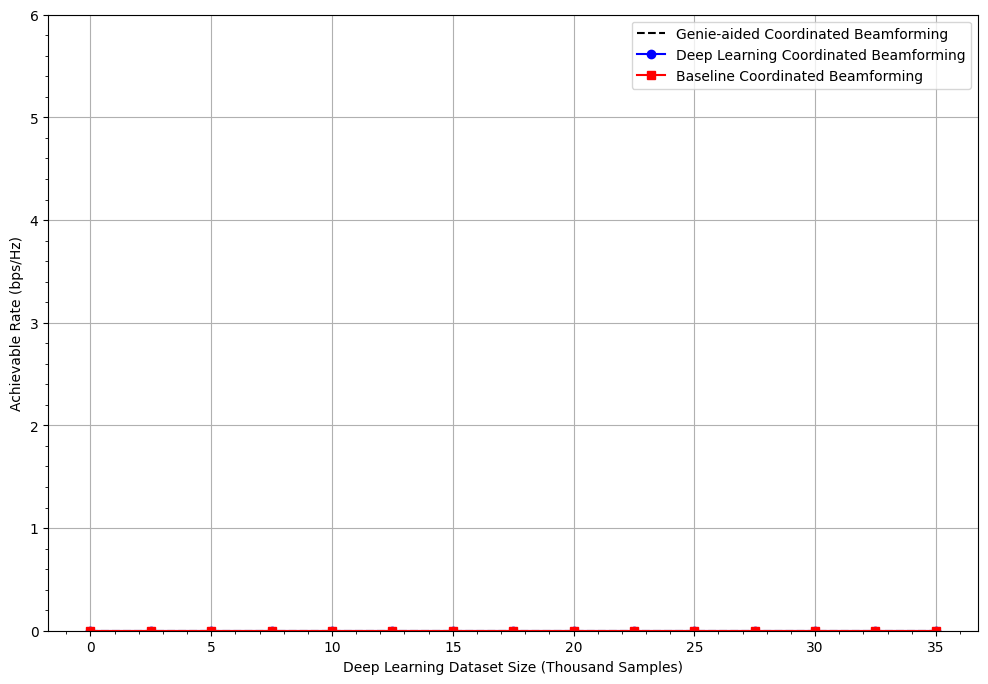

In [62]:
import matplotlib.pyplot as plt

#%% Read Results
file_list = sorted(glob.glob('Test_code_output/DL_Result*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
num_files = len(file_list)

user_index = []
pred_beams = []
opt_beams = []
for file in tqdm(file_list, desc='Reading DL results'):
    matfile = loadmat(file)
    l1 = []
    l2 = []
    for idx in range(num_bs):
        l1.append(matfile['TX'+str(idx+1)+'Pred_Beams'])
        l2.append(matfile['TX'+str(idx+1)+'Opt_Beams'])

    pred_beams.append(l1)
    opt_beams.append(l2)
    user_index.append(matfile['user_index'])


Pn = -204 + 10*np.log10(BW) # Noise power in dB
SNR = 10**(.1*(0-Pn))

ach_rate_DL = np.zeros(num_files)
ach_rate_opt = np.zeros(num_files)

eff_rate = np.zeros(num_files)
opt_rate = np.zeros(num_files)
for file_idx in tqdm(np.arange(num_files), desc = 'Calculating results'):
    user_index_file = user_index[file_idx].flatten()
    for ue_idx in range(len(user_index_file)):
        eff_ch = []
        opt_ch = []
        for bs_idx in range(num_bs):
            if file_idx == 0: # Random BF - 0 Samples
                pred_beam_idx = np.random.randint(num_beams)
            else:
                pred_beam_idx = np.argmax(pred_beams[file_idx][bs_idx][ue_idx])
            opt_beam_idx = np.argmax(opt_beams[file_idx][bs_idx][ue_idx])
            #ch_single_bs = dataset[bs_idx]['user']['channel'][user_index_file[ue_idx]].squeeze()
            ch_single_bs = sionna_data['DL_input'][ue_idx, bs_idx, :]
            ch_single_bs = ch_single_bs.reshape(-1, 1)  # (64, 1)
            ch_single_bs = np.nan_to_num(ch_single_bs)
            beam_vec_pred = F[:, pred_beam_idx].reshape(-1, 1)  # (64, 1)
            beam_vec_opt = F[:, opt_beam_idx].reshape(-1, 1)    # (64, 1)

            eff_ch_single_pred = ch_single_bs.conj().T @ beam_vec_pred  # (1, 64) @ (64, 1) -> (1, 1)
            opt_ch_single_pred = ch_single_bs.conj().T @ beam_vec_opt

            eff_ch.append(eff_ch_single_pred.squeeze())
            opt_ch.append(opt_ch_single_pred.squeeze())
        
        eff_ch = np.array(eff_ch)
        opt_ch = np.array(opt_ch)
        # print(SNR)
        # print(eff_ch)
        # print(opt_ch)
        # print(eff_ch.shape)
        # print(opt_ch.shape)
        eff_rate[file_idx] += np.log2(1 + SNR * np.sum(np.abs(eff_ch) ** 2))
        opt_rate[file_idx] += np.log2(1 + SNR * np.sum(np.abs(opt_ch) ** 2))

    eff_rate[file_idx] /= len(user_index_file)*num_OFDM
    opt_rate[file_idx] /= len(user_index_file)*num_OFDM


# % Eff achievable rate calculations
theta_user=(102/1)*np.pi/180
alpha=60*np.pi/180
distance_user=10
Tc_const=(distance_user*theta_user)/(2*np.sin(alpha)) # ms
Tt=10*1e-6; # ms

v_mph=50
v=v_mph*1000*1.6/3600 # m/s
Tc=Tc_const/v

overhead_opt=1-(num_beams*Tt)/Tc # overhead of beam training
overhead_DL=1-Tt/Tc # overhead of proposed DL method

#%% Plotting the figure
DL_size_array=np.arange(0, 2.5*(num_files), 2.5);
print(f"DL_size_array.shape: {DL_size_array.shape}, opt_rate.shape: {opt_rate.shape}")
print("opt_rate min/max:", opt_rate.min(), opt_rate.max())
print("eff_rate min/max:", eff_rate.min(), eff_rate.max())

fig, ax = plt.subplots()
plt.plot(DL_size_array, opt_rate, '--k', label = 'Genie-aided Coordinated Beamforming')
plt.plot(DL_size_array, eff_rate*overhead_DL, '-bo', label = 'Deep Learning Coordinated Beamforming')
plt.plot(DL_size_array, opt_rate*overhead_opt, '-rs', label = 'Baseline Coordinated Beamforming')
plt.ylim([0, 6])
plt.minorticks_on()
plt.grid()
plt.xlabel('Deep Learning Dataset Size (Thousand Samples)')
plt.ylabel('Achievable Rate (bps/Hz)')
plt.legend()
plt.savefig('result.png')
